# [5SSD0] Probabilistic Programming - Assignment 2

Year: 2023-2024

In this assignment, we will go through the Bayesian model design cycle:

 <img src="figures/modelling-procedure.png" alt="" width="600"> 

In the second part of the assignment, you will continue improving your model. This time, you will adopt a variational Bayesian procedure.

In [ ]:
using CSV
using DataFrames
using LinearAlgebra
using ProgressMeter
using RxInfer
using Plots
default(label="",
        grid=false, 
        linewidth=3, 
        markersize=4,
        guidefontsize=12, 
        margins=15Plots.pt)

## Problem: Forecasting Air Quality

Many Europeans suspect that the air quality in their city is declining. A [recent study](https://doi.org/10.1016/j.snb.2007.09.060) measured the air quality of a major city in North Italy using an electronic nose. The measurements were made in the middle of the city and reflect urban activity. We will inspect the specific chemical concentrations found and build a model to accurately predict CO for future time points.

![https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds](figures/air-milan-wide.png)

Photograph taken by Claudio Furlan/LaPresse/Zuma Press/Rex/Shutterstock ([link](https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds))

### Data

The data can be found here: https://archive.ics.uci.edu/ml/datasets/Air+Quality. I've done some pre-processing and selected the most important features. In this assignment we will infer parameters in a model of the data and predict air quality in the future. For that purpose, the data has been split into past and future.

In [2]:
past_data = DataFrame(CSV.File("data/airquality_past.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-10T18:00:00,1360.0
2,2004-03-10T19:00:00,1292.0
3,2004-03-10T20:00:00,1402.0
4,2004-03-10T21:00:00,1376.0
5,2004-03-10T22:00:00,1272.0
6,2004-03-10T23:00:00,1197.0
7,2004-03-11T00:00:00,1185.0
8,2004-03-11T01:00:00,1136.0
9,2004-03-11T02:00:00,1094.0


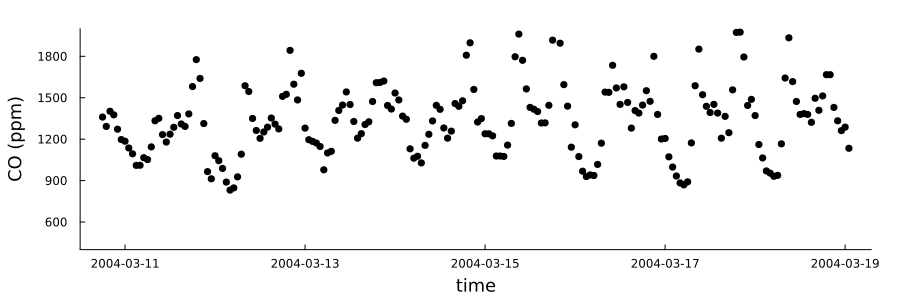

In [3]:
scatter(past_data[:,1], 
        past_data[:,2], 
        size=(900,300), 
        color="black", 
        xlabel="time", 
        ylabel="CO (ppm)",
        ylims=[400,2000])

## 1. Model specification and parameter estimation

In the first assignment, we set the noise level $\tau$ to $1.0$. But that was based on convenience, not on domain expertise or data. We are now going to infer this quantity, simulteanously with the AR coefficients. This requires specifying an appropriate prior probability distribution over $\tau$ and adjusting the inference procedure. 

Tasks:
- [1pt] Infer the approximate posteriors for $\theta$ and $\tau$, for model order $M=2$.
- [1pt] Visualize both posterior distributions, over appropriate ranges.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


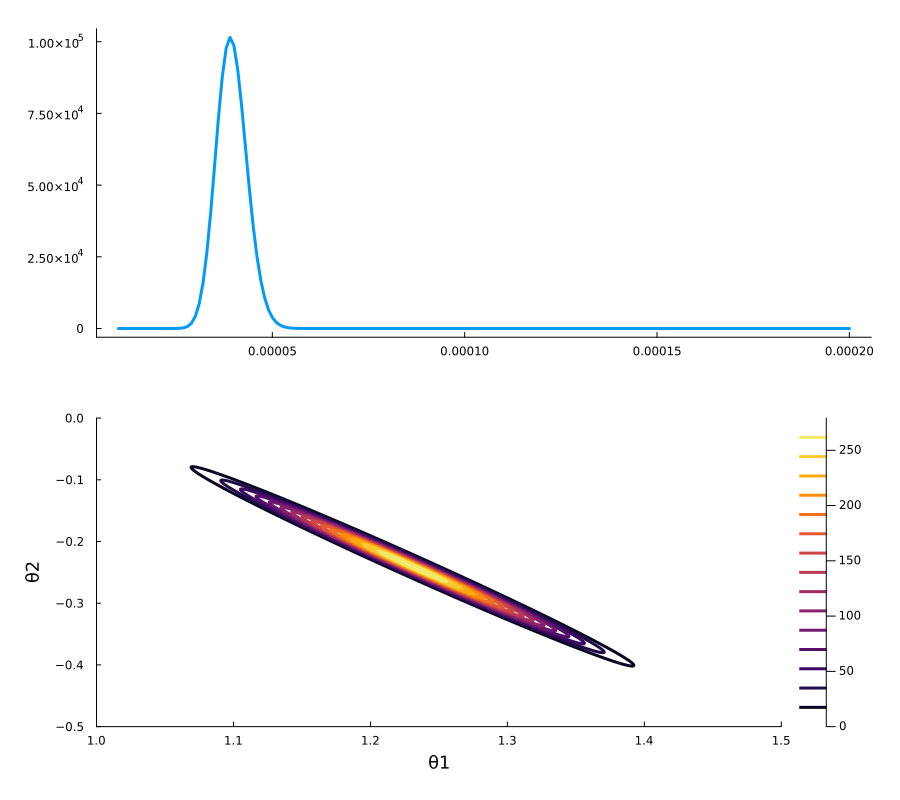

In [4]:
### BEGIN SOLUTION

# Number of iterations of variational inference
n_iters = 10;

# Model order
M = 2;

# Number of data points
T = size(past_data,1);

# Prepare data
y_k    = [past_data[i,2] for i in (M+1):T]
y_prev = [past_data[i-1:-1:i-M,2] for i in (M+1):T]

# Specify parameters of prior distributions 
prior_params = Dict(:θ => (zeros(M), diagm(ones(M))),
                    :τ => (1.0, 1.0))

@model function auto_regression2(prior_params; model_order=2, num_samples=1)
    
    x = datavar(Vector{Float64}, num_samples)
    y = datavar(Float64, num_samples)
    
    # Prior coefficients
    θ ~ MvNormal(mean = prior_params[:θ][1], covariance = prior_params[:θ][2])
    
    # Prior noise precision
    τ ~ Gamma(shape = prior_params[:τ][1], rate = prior_params[:τ][2])
    
    for i = 1:num_samples
        
        # Likelihood
        y[i] ~ Normal(mean = dot(θ,x[i]), precision = τ)
        
    end
    return y, x, θ, τ
end

constraints = @constraints begin
    q(θ,τ) = q(θ)q(τ)
end

results = inference(
    model         = auto_regression2(prior_params, model_order=M, num_samples=T-M),
    data          = (x = y_prev, y = y_k,),
    constraints   = constraints,
    initmarginals = (θ = MvNormal(prior_params[:θ]...), τ = Gamma(prior_params[:τ]...)),
    returnvars    = (θ = KeepLast(), τ = KeepLast(),),
    iterations    = n_iters,
    free_energy   = true,
    showprogress  = true,
)

# Posterior for noise precision
p1 = plot(1e-5:1e-6:2e-4, t -> pdf(results.posteriors[:τ], t))

# Draw contour plots of posterior distribution of AR coefficients
x1 = range( 1.0, length=500, stop=1.5)
x2 = range(-0.5, length=500, stop=0.0)
p2 = contour(x1, x2, (x1,x2) -> pdf(results.posteriors[:θ], [x1,x2]), xlabel="θ1", ylabel="θ2", label="")

plot(p1, p2, layout=(2,1), size=(900,800))

### END SOLUTION

## 2. Predictions & model evaluation

In this model, the posterior predictive distribution becomes:

$$ p(y_{k+1} \mid \bar{y}_{k}, \mathcal{D}) = \int p(y_{k+1} \mid \theta, \tau, \bar{y}_{k}) p(\theta \mid \mathcal{D}) p(\tau \mid \mathcal{D}) \, \mathrm{d}\theta \, \mathrm{d}\tau . $$

This integral is a bit complicated. As such, you are allowed to use a simplified form:

$$ p(y_{k+1} \mid y_{k}, \mathcal{D}) = \int \mathcal{N}(y_{k+1} \mid \theta^{\top} \bar{y}_{k}, \hat{\tau}^{MAP} ) p(\theta \mid \mathcal{D}) \, \mathrm{d}\theta \,  , $$

where $\hat{\tau}^{MAP}$ refers to the most probable value under the posterior distribution, i.e., $\hat{\tau}^{MAP} = \arg\max p(\tau \mid \mathcal{D})$.

Tasks:
- [1pt] Derive the parameters of the simplified posterior predictive distribution and compute the 1-step ahead predictions on the data set. Plot the first 10 predictions (_mean and 1 standard deviation_) along with the data $y_{2:11}$.

---

Note that if you failed to infer a posterior distribution in the previous question, you can still answer this question using a standard normal, $p(\theta) = \mathcal{N}(0,1)$.

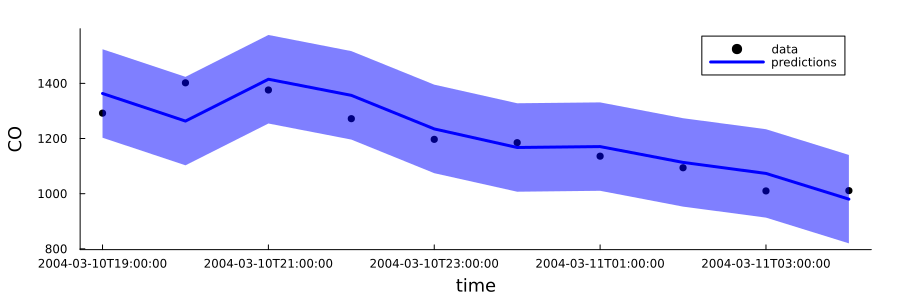

In [5]:
### BEGIN SOLUTION

# Preallocate predictions
sim_mean = zeros(T)
sim_stds = zeros(T)

# Initialize recursive previous
y_prev = past_data[1:M,2]

# Extract parameters of posterior
mθ, Sθ = mean_cov(results.posteriors[:θ])
mτ     = mode(results.posteriors[:τ])

for t = 2:T
    
    # Compute parameters of posterior
    sim_mean[t] = dot(mθ,y_prev)
    sim_stds[t] = sqrt(y_prev'*Sθ*y_prev + inv(mτ))
    
    # Update data
    y_prev = past_data[t:-1:t-M+1,2]
    
end

scatter(past_data[2:11,1], past_data[2:11,2], color="black", label="data", xlabel="time", ylabel="CO")
plot!(past_data[2:11,1], sim_mean[2:11], ribbon=sim_stds[2:11], color="blue", size=(900,300), label="predictions")

### END SOLUTION

## 3. Model selection & deployment

Vary the autoregressive model order $M$ and use free energy as a model evaluation criterion. Which model is the best?

Tasks:
- [1pt] Compute the free energies for a given range of $M$ and report the best performing one.
- [1pt] Deploy the best model on future data and visualize 1-step ahead predictions (_mean and 1 standard deviation_).

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


FE indicates M = 32 is optimal.


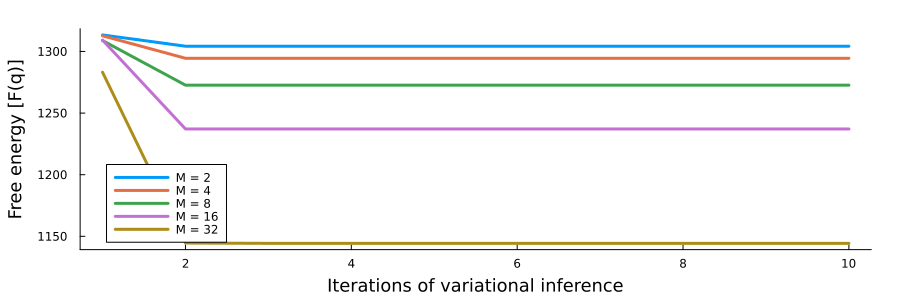

In [6]:
### BEGIN SOLUTION

# Model order range
model_orders = [2,4,8,16,32];

# Preallocate free energy
FE = zeros(length(model_orders), n_iters)

# Preallocate list of posteriors
posts = Vector(undef, length(model_orders))

# Loop over model orders
@showprogress for (j,m) in enumerate(model_orders)
    
    # Prepare data
    y_k    = [past_data[i,2] for i in (m+1):T]
    y_prev = [past_data[i-1:-1:i-m,2] for i = (m+1):T]

    # Specify parameters of prior distributions 
    prior_params = Dict(:θ => (exp.(-(1:m)), diagm(ones(m))),
                        :τ => (1.0, 1.0))

    results = inference(
        model         = auto_regression2(prior_params, model_order=m, num_samples=T-m),
        data          = (x = y_prev, y = y_k,),
        constraints   = constraints,
        initmarginals = (θ = MvNormal(prior_params[:θ]...), τ = Gamma(prior_params[:τ]...)),
        returnvars    = (θ = KeepLast(), τ = KeepLast(),),
        iterations    = n_iters,
        free_energy   = true,
        showprogress  = true,
    )
    
    # Store final FE
    FE[j,:] = results.free_energy
    
    # Save posteriors
    posts[j] = results.posteriors
end

# Extract best model and report
M_best = model_orders[argmin(FE[:,end])]
println("FE indicates M = "*string(M_best)*" is optimal.")

# Visualize free energies
plot(1:n_iters, 
     FE', 
     xlabel="Iterations of variational inference", 
     ylabel="Free energy [F(q)]", 
     labels = cat([["M = $m"] for m in model_orders]..., dims=2), 
     size=(900,300))

### END SOLUTION

In [7]:
# Load test data
future_data = DataFrame(CSV.File("data/airquality_future.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-19T02:00:00,999.0
2,2004-03-19T03:00:00,961.0
3,2004-03-19T04:00:00,934.0
4,2004-03-19T05:00:00,913.0
5,2004-03-19T06:00:00,969.0
6,2004-03-19T07:00:00,1182.0
7,2004-03-19T08:00:00,1740.0
8,2004-03-19T09:00:00,1819.0
9,2004-03-19T10:00:00,1427.0


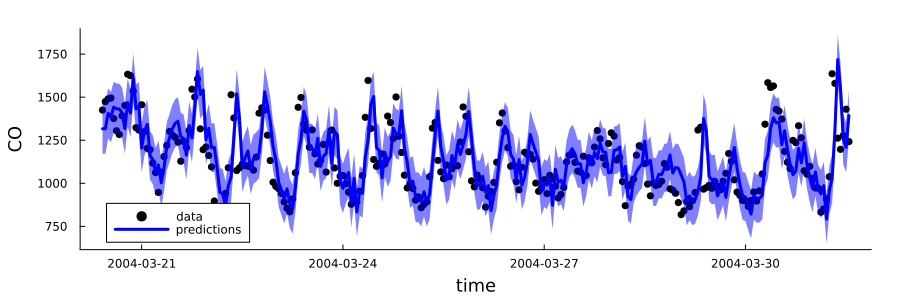

In [8]:
### BEGIN SOLUTION

# Select posterior
best_post = posts[argmin(FE[:,end])]

# Extract parameters of selected posterior
mθ, Sθ = mean_cov(best_post[:θ])
mτ     = mode(best_post[:τ])

T = size(future_data,1)

# Preallocate predictions
sim_mean = zeros(T)
sim_stds = zeros(T)

# Initialize recursive previous
y_prev = future_data[M_best:-1:1,2]

for t = (M_best+1):T
    
    # Compute parameters of posterior
    sim_mean[t] = mθ'*y_prev
    sim_stds[t] = sqrt(y_prev'*Sθ*y_prev + inv(mτ))
    
    # Update data
    y_prev = future_data[t-1:-1:t-M_best,2]
    
end

ix = (M_best+1):300
scatter(future_data[ix,1], future_data[ix,2], color="black", label="data", xlabel="time", ylabel="CO")
plot!(future_data[ix,1], sim_mean[ix], ribbon=sim_stds[ix], color="blue", size=(900,300), label="predictions")

### END SOLUTION